In [1]:
import numpy as np
from DeepPeak.signals import generate_square_dataset
# from DeepPeak import models
from DeepPeak.signals import generate_gaussian_dataset
from DeepPeak.utils.visualization import plot_training_history, Visualizer
from DeepPeak.utils.training_utils import dataset_split
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
from tensorflow.keras.models import load_model  # type: ignore

from tensorflow import keras
keras.utils.register_keras_serializable()

<function keras.src.saving.object_registration.register_keras_serializable.<locals>.decorator(arg)>

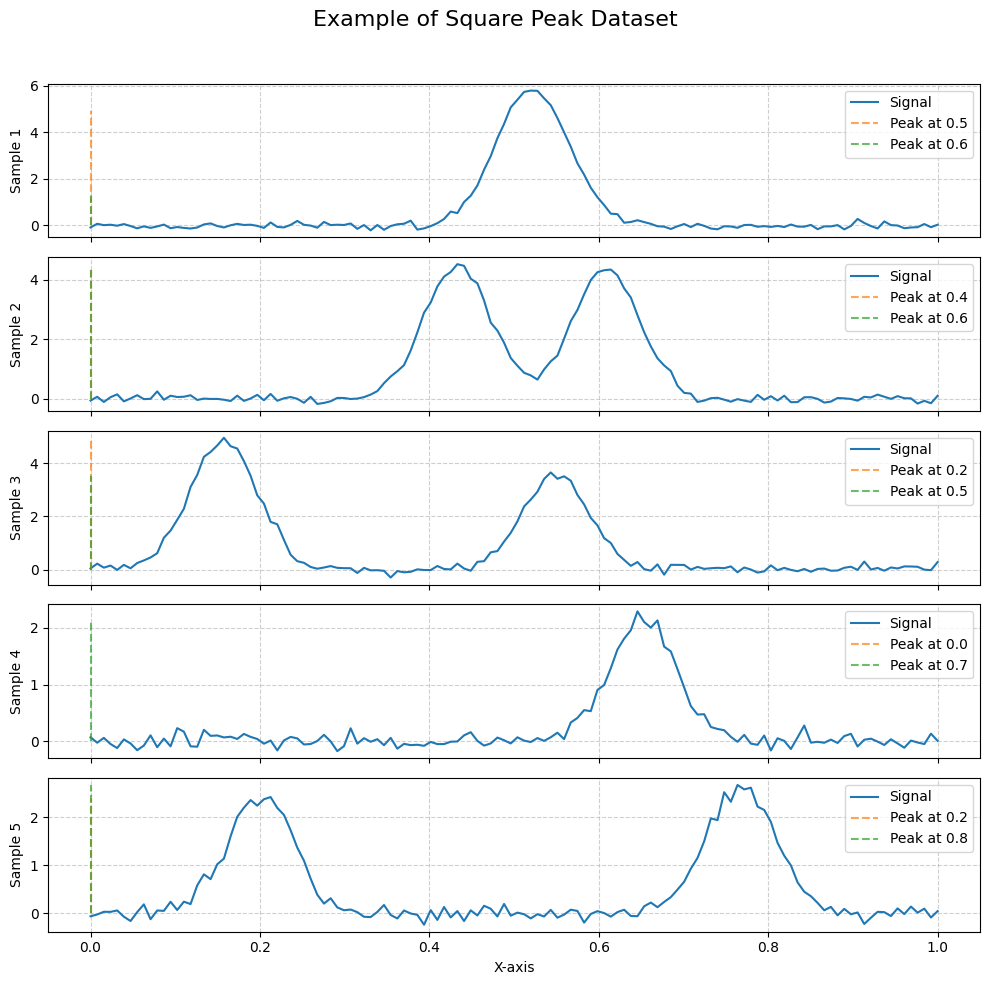

In [105]:
# Parameters for dataset generation
sample_count = 6000
sequence_length = 128
peak_count = (1, 2)
amplitude_range = (1, 5)
center_range = (0.1, 0.9)
width_range = 0.04
noise_std = 0.1
normalize = False
normalize_x = True



# Generate a square peak dataset
signals, amplitudes, peak_counts, positions, widths, x_values = generate_gaussian_dataset(
    sample_count=sample_count,
    sequence_length=sequence_length,
    peak_count=peak_count,
    amplitude_range=amplitude_range,
    center_range=center_range,
    width_range=width_range,
    noise_std=noise_std,
    normalize=normalize,
    normalize_x=normalize_x,
    nan_values=0,
    sort_peak='position',
    categorical_peak_count=True
)

# Plot the dataset
plot_dataset(
    signals=signals,
    amplitudes=amplitudes,
    positions=positions,
    x_values=x_values,
    num_samples=5,
    title="Example of Square Peak Dataset"
)

dataset = dataset_split(
    signals=signals,
    positions=positions,
    amplitudes=amplitudes,
    peak_counts=peak_counts,
    widths=widths,
    test_size=0.2,
    random_state=None,
)

In [106]:
import numpy as np
from scipy.optimize import linear_sum_assignment

@keras.utils.register_keras_serializable()
def permutation_invariant_loss(y_true, y_pred):
    # y_true and y_pred shape: (batch_size, max_peak_count)
    # Sort each row
    y_true_sorted = tf.sort(y_true, axis=1)
    y_pred_sorted = tf.sort(y_pred, axis=1)
    
    # Compute MSE between sorted arrays
    return tf.reduce_mean(tf.square(y_true_sorted - y_pred_sorted))

In [115]:
import tensorflow as tf
from tensorflow.keras import layers, models


def block(intake, n_filter, kernel_size):
    x = layers.Conv1D(n_filter, kernel_size, padding='same', use_bias=False)(intake)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def get_model(input_length: int, max_peak_count: int) -> models.Model:    
    input_layer = layers.Input(shape=(input_length, 1))

    # x = block(intake=input_layer, n_filter=16, kernel_size=5)

    # x = block(intake=input_layer, n_filter=20, kernel_size=5)

    # x = layers.AveragePooling1D(pool_size=2)(x)

    # x = block(intake=input_layer, n_filter=24, kernel_size=5)

    # x = layers.AveragePooling1D(pool_size=2)(x)

    # x = block(intake=input_layer, n_filter=28, kernel_size=5)

    # x = layers.AveragePooling1D(pool_size=2)(x)

    x = block(intake=input_layer, n_filter=16, kernel_size=5)

    x = block(intake=input_layer, n_filter=20, kernel_size=5)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    # Positions in [0,1] range -> multiply by input_length at inference to get actual indices
    output = layers.Dense(max_peak_count, activation='sigmoid', name="positions")(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model


import tensorflow as tf
from tensorflow.keras import layers, models

def get_model(input_length, max_peak_count):
    inputs = tf.keras.Input(shape=(input_length, 1))
    
    # Encoder
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Bottleneck
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)

    # Output Layer
    outputs = layers.Conv1D(max_peak_count, kernel_size=1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# model = build_peak_detection_model((256, 1))
# model.summary()



In [116]:

# Define the callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",          # Path to save the best model
    monitor="val_loss",                # Metric to monitor (e.g., "val_loss" or "val_accuracy")
    save_best_only=True,               # Save only the best model
    save_weights_only=False,           # Save the entire model (set True to save only weights)
    mode="min",                        # "min" for loss (smaller is better), "max" for accuracy
    verbose=0                          # Display a message when saving the model
)

class ExponentialLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs['loss']
        print(f'Epoch {epoch + 1}: Loss = {loss:.7e}')


model = get_model(input_length=128, max_peak_count=2)

model.compile(optimizer='adam', loss=permutation_invariant_loss)

history = model.fit(
    dataset['train']['signals'],
    dataset['train']['positions'],
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_callback, ExponentialLossCallback()],
    verbose=0
)

model = load_model("best_model.keras")

ValueError: Dimensions must be equal, but are 32 and 128 for '{{node compile_loss/permutation_invariant_loss/sub}} = Sub[T=DT_FLOAT](compile_loss/permutation_invariant_loss/sort/Neg_1, compile_loss/permutation_invariant_loss/sort_1/Neg_1)' with input shapes: [32,2], [32,128,2].

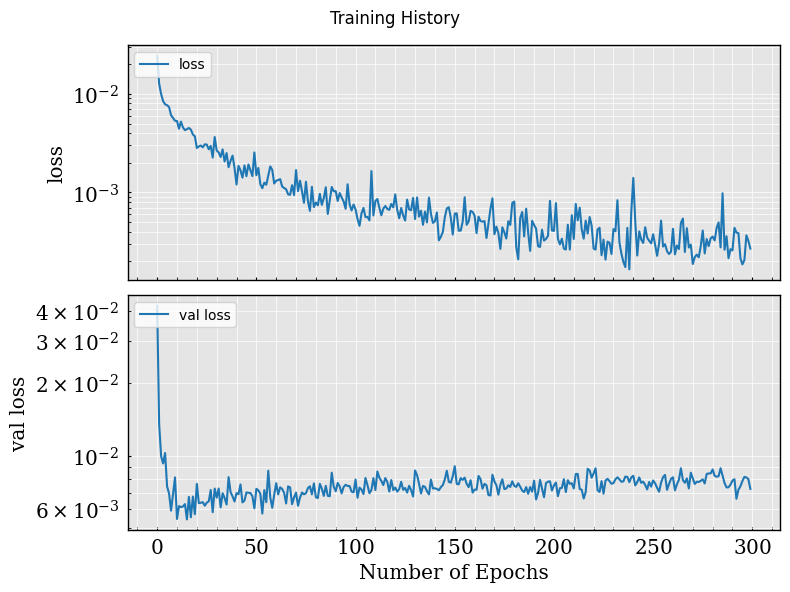

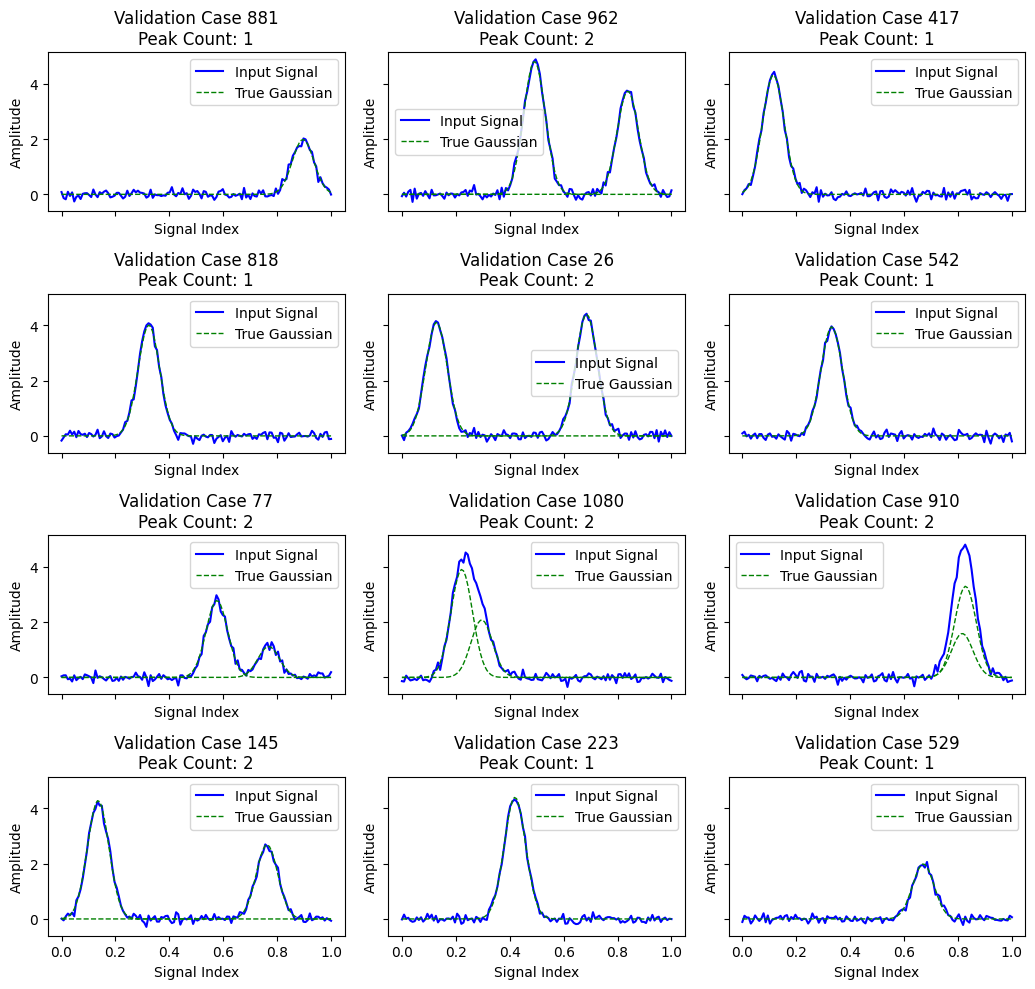

In [117]:
plot_training_history(history, filtering=['*loss*'])

visualize_validation_cases(
    model=model,
    model_type='gaussian',
    validation_data=dataset['test'],
    sequence_length=128,
    num_examples=12,
    n_columns=3
)

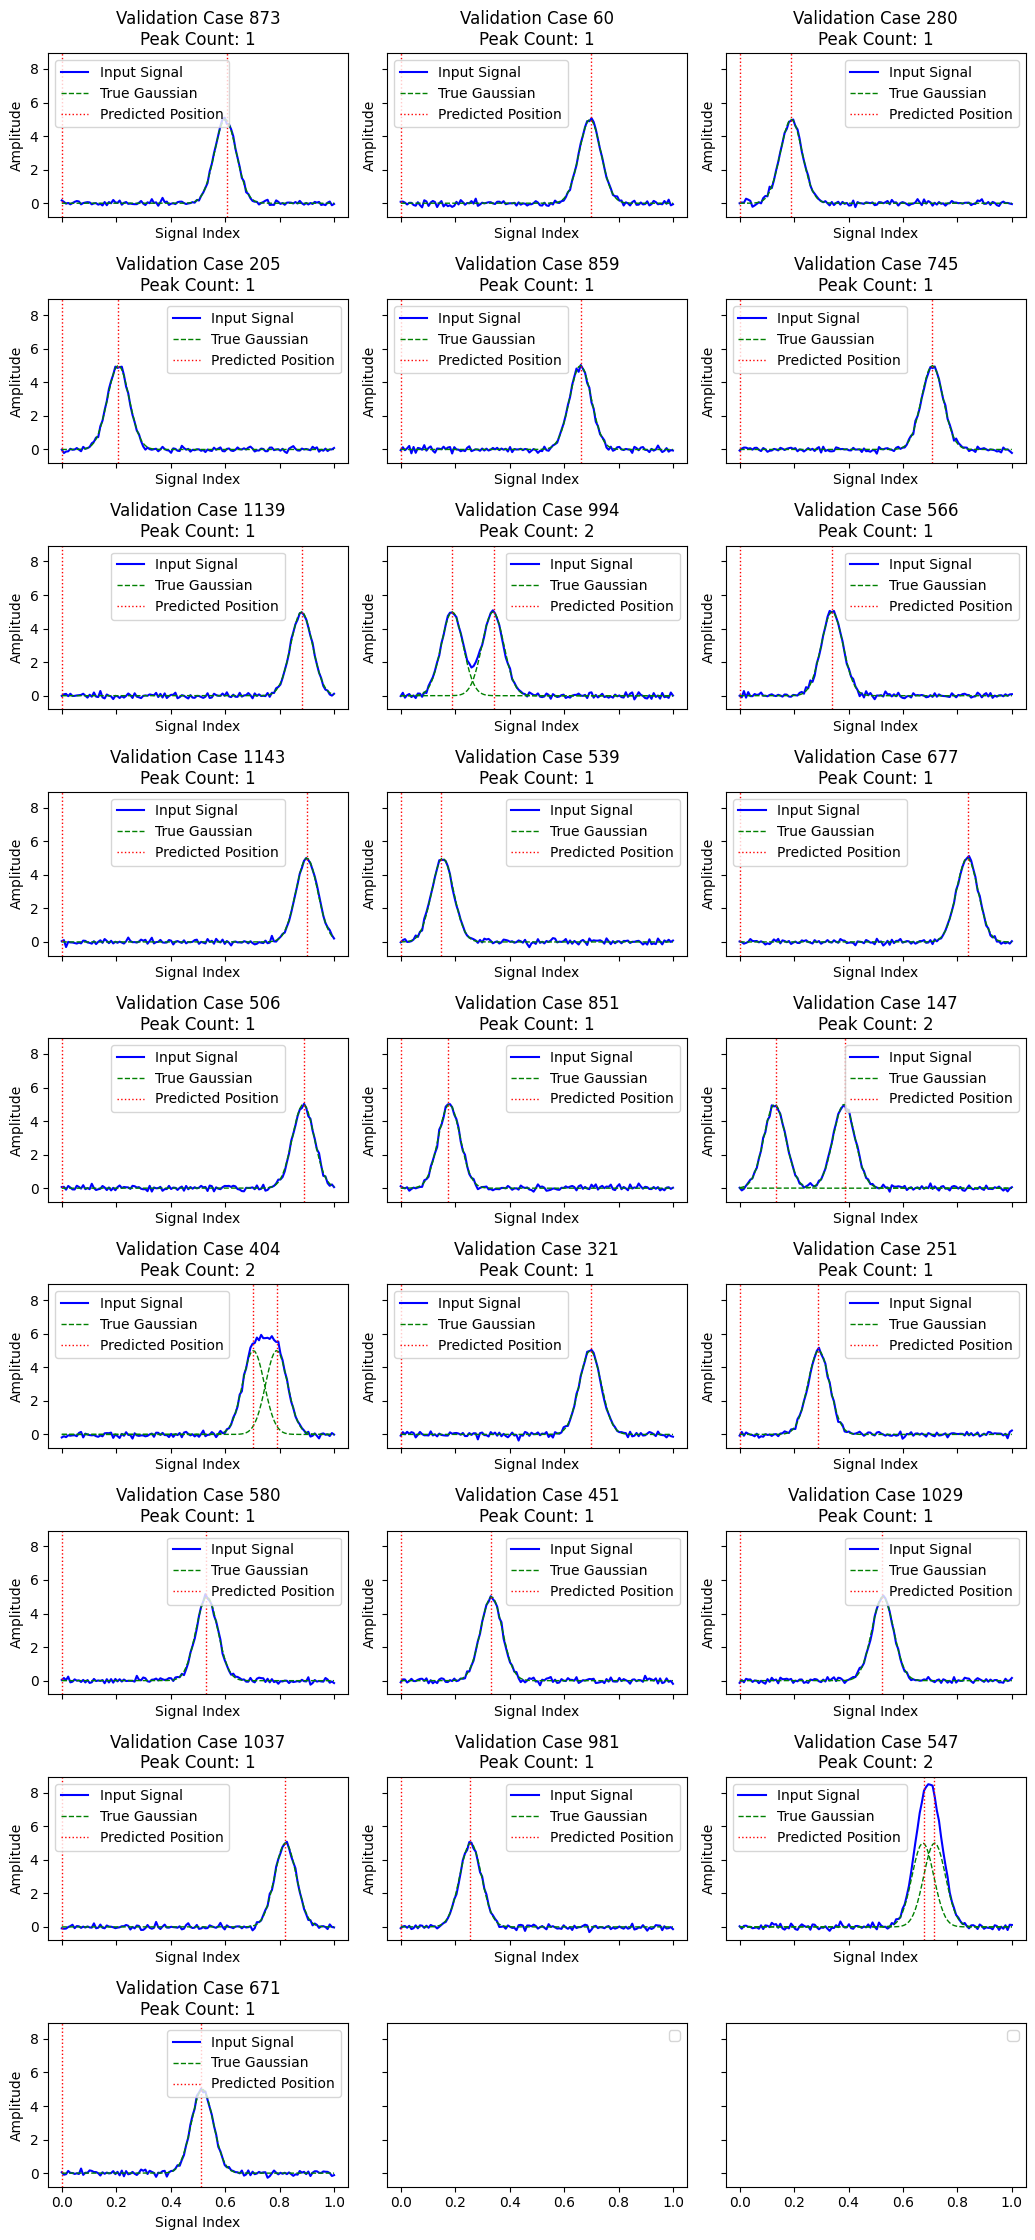

In [104]:
visualize_validation_cases(
    model=model,
    model_type='gaussian',
    validation_data=dataset['test'],
    sequence_length=128,
    num_examples=25,
    n_columns=3
)

In [6]:

def build_position_model(input_shape, num_peaks):

    @keras.utils.register_keras_serializable()
    def permutation_invariant_loss(y_true, y_pred):
        # y_true and y_pred shape: (batch_size, max_peak_count)
        # Sort each row
        y_true_sorted = tf.sort(y_true, axis=1)
        y_pred_sorted = tf.sort(y_pred, axis=1)
        
        # Compute MSE between sorted arrays
        return tf.reduce_mean(tf.square(y_true_sorted - y_pred_sorted))
    
    inputs = tf.keras.Input(shape=input_shape)

    # --- Encoder ---
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)  
    # shape => (batch, length/2, 32)

    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # shape => (batch, length/4, 64)

    # Bottleneck (retain partial spatial resolution)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    # shape => (batch, length/4, 128)

    # --- Flatten instead of global pool ---
    x = layers.Flatten()(x)  
    # shape => (batch, (length/4) * 128)

    # --- Dense layers to regress position ---
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_peaks, activation=None)(x)  # single scalar for position

    model = models.Model(inputs, outputs={'positions': outputs})
    model.compile(optimizer='adam', loss=permutation_invariant_loss)
    return model


def build_ROI_model(sequence_length):
    inputs = tf.keras.Input(shape=(sequence_length, 1))

    # Encoder
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Bottleneck
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)

    # Output Layer
    ROI = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='ROI')(x)

    model = models.Model(inputs, outputs={'ROI': ROI})

    model.compile(optimizer='adam', loss={'ROI': 'binary_crossentropy'}, metrics=['accuracy'])

    return model


In [121]:
NUM_PEAKS = 3

# Dataset generation parameters
sample_count = 6000
sequence_length = 128
peak_count = (1, NUM_PEAKS)
amplitude_range = (1, 20)
center_range = (0.1, 0.9)
width_range = 0.04
noise_std = 0.03
normalize = False
normalize_x = True

# Generate the dataset
signals, amplitudes, peak_counts, positions, widths, x_values, ROI = generate_gaussian_dataset(
    sample_count=sample_count,
    sequence_length=sequence_length,
    peak_count=peak_count,
    amplitude_range=amplitude_range,
    center_range=center_range,
    width_range=width_range,
    noise_std=noise_std,
    normalize=normalize,
    normalize_x=normalize_x,
    nan_values=0,
    sort_peak='position',
    categorical_peak_count=True,
    probability_range=(0.1, 0.1)
)


# Train-test split
dataset = dataset_split(
    signals=signals,
    positions=positions,
    amplitudes=amplitudes,
    peak_counts=peak_counts,
    ROI=ROI,
    widths=widths,
    test_size=0.2,
    random_state=None,
)

# Build the model
roi_model = build_ROI_model(sequence_length)

# Train the model
history = roi_model.fit(
    dataset['train']['signals'], dataset['train']['ROI'],
    validation_data=(dataset['test']['signals'], dataset['test']['ROI']),
    epochs=150,
    batch_size=32
)

Epoch 1/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9662 - loss: 0.1893 - val_accuracy: 0.9920 - val_loss: 0.0255
Epoch 2/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9919 - loss: 0.0253 - val_accuracy: 0.9920 - val_loss: 0.0226
Epoch 3/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9918 - loss: 0.0225 - val_accuracy: 0.9921 - val_loss: 0.0229
Epoch 4/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9919 - loss: 0.0214 - val_accuracy: 0.9920 - val_loss: 0.0201
Epoch 5/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9920 - loss: 0.0198 - val_accuracy: 0.9923 - val_loss: 0.0190
Epoch 6/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9921 - loss: 0.0188 - val_accuracy: 0.9921 - val_loss: 0.0188
Epoch 7/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9922 - loss: 0.0184 - val_accuracy: 0.9920 - val_loss: 0.0188
Epoch 8/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9923 - loss: 0.0178 - val_accu

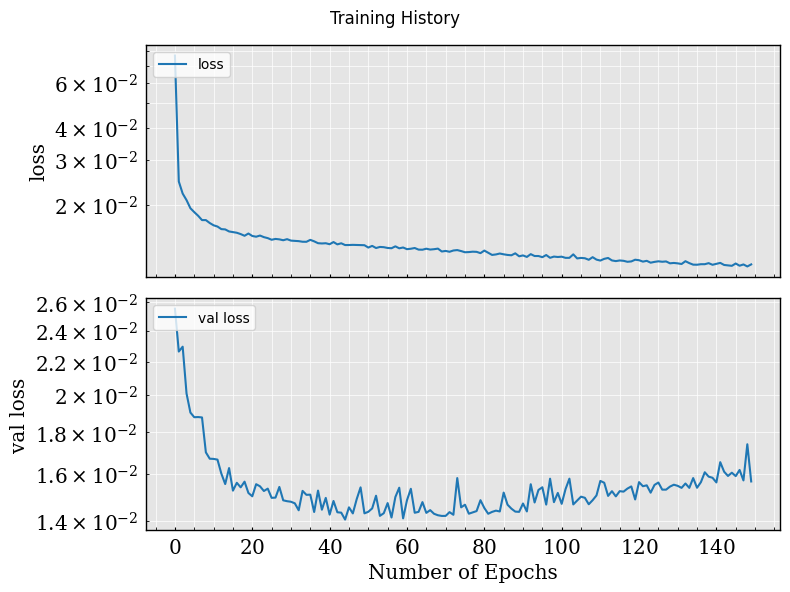

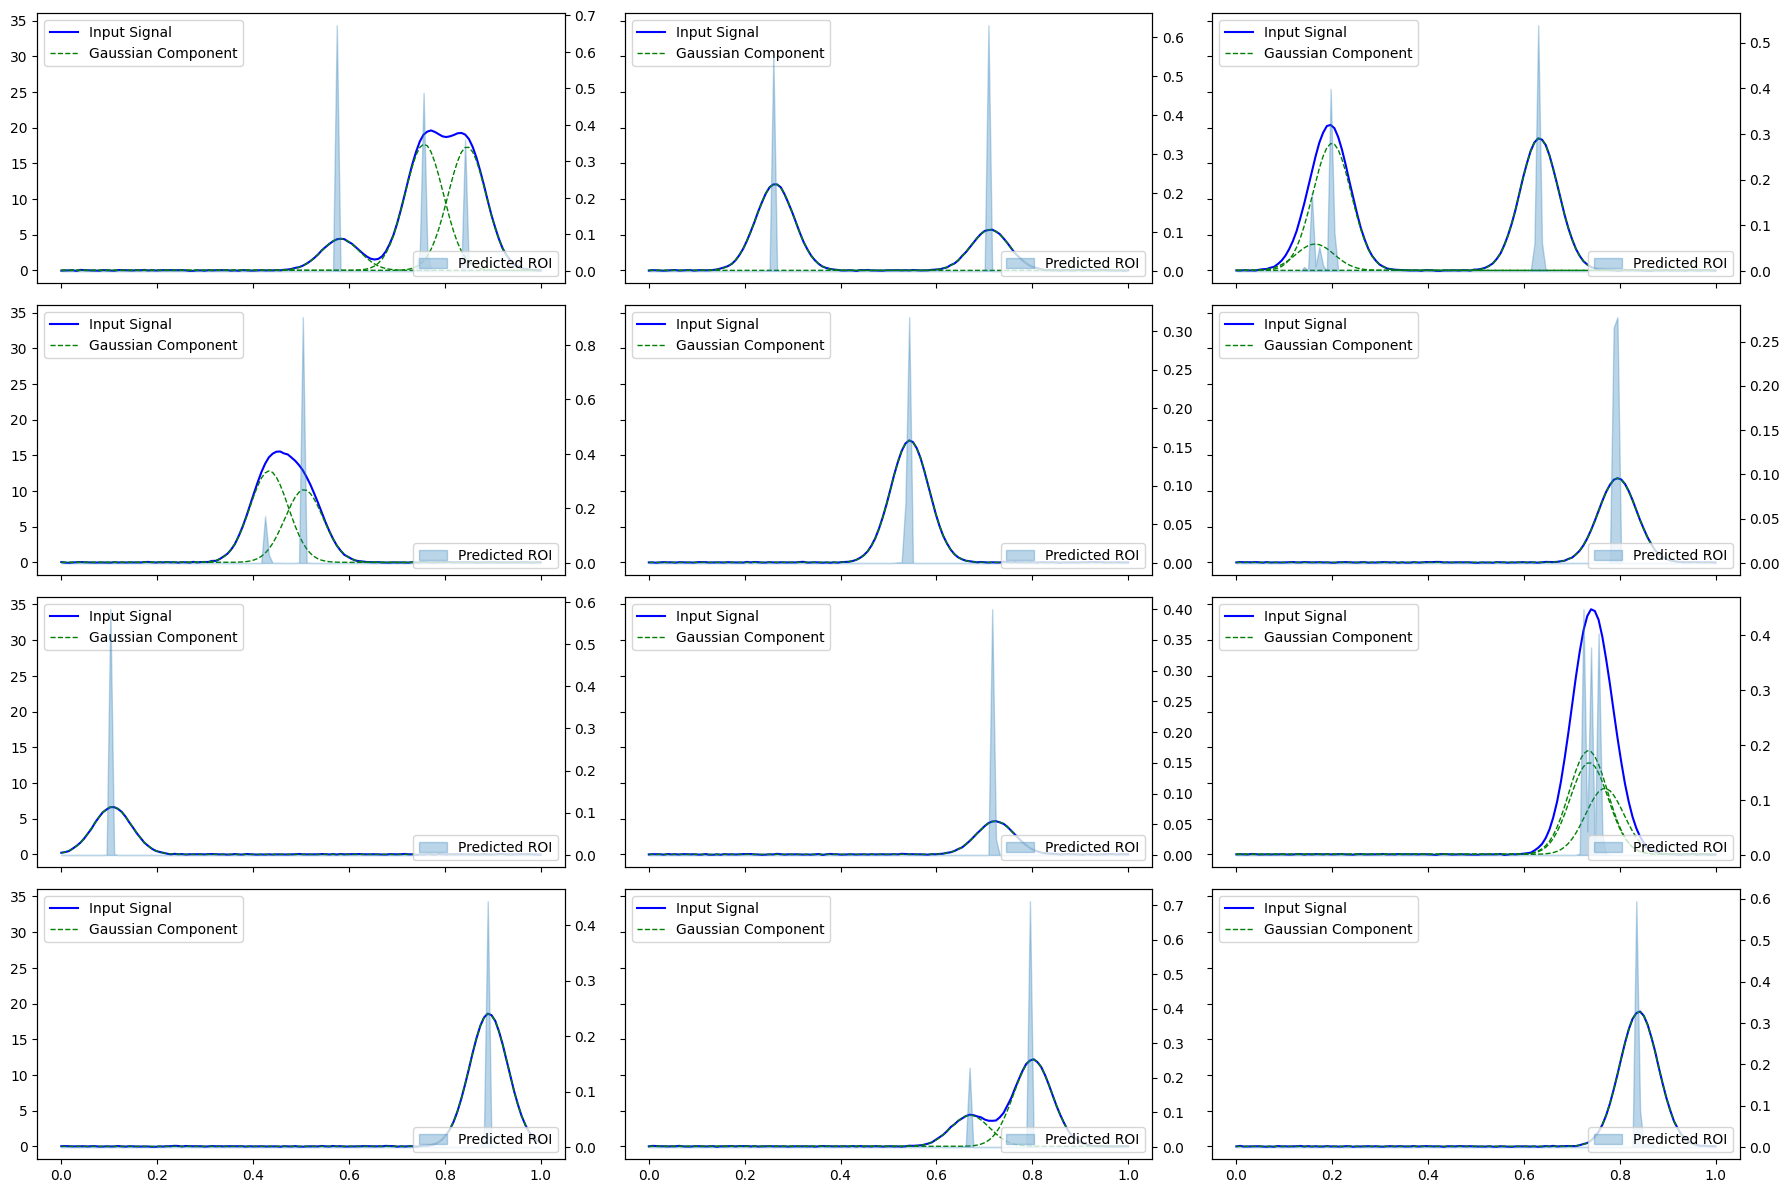

In [124]:
plot_training_history(history, filtering=['*loss*'])

visualizer = Visualizer(
    sequence_length=128,
    signal_type='gaussian',
    n_columns=3,
    unit_size=(6, 3)
)

roi_predictions = roi_model.predict(dataset['test']['signals'], verbose=0)


visualizer.visualize_validation_cases(
    predictions=roi_predictions,
    validation_data=dataset['test'],
    num_examples=12
)



In [112]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_peak_position_model(input_shape):
    """
    Builds a 1D CNN that ingests (length, 2) shape data:
      - channel 0: raw signal
      - channel 1: ROI mask (values in [0..1])
    and outputs a single scalar for the peak position.

    Parameters
    ----------
    input_shape : tuple
        (sequence_length, num_channels), e.g. (128, 2)

    Returns
    -------
    model : tf.keras.Model
        A compiled Keras model that predicts one scalar (peak position).
    """
    @keras.utils.register_keras_serializable()
    def permutation_invariant_loss(y_true, y_pred):
        # y_true and y_pred shape: (batch_size, max_peak_count)
        # Sort each row
        y_true_sorted = tf.sort(y_true, axis=1)
        y_pred_sorted = tf.sort(y_pred, axis=1)
        
        # Compute MSE between sorted arrays
        return tf.reduce_mean(tf.square(y_true_sorted - y_pred_sorted))
    
    inputs = tf.keras.Input(shape=input_shape)  # e.g. (None, 128, 2)

    # --- Convolutional encoder ---
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)  # reduces length by half

    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # reduces length by half

    # We keep partial resolution to preserve positional info
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    # x = layers.Dropout(0.4)(x)
    # shape -> (batch, length/4, 128)

    # --- Flatten and Dense layers for regression ---
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)

    # One output for peak position
    outputs = layers.Dense(NUM_PEAKS, activation=None)(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=permutation_invariant_loss)
    return model

roi_predictions = roi_model.predict(dataset['train']['signals'], verbose=0)

model = build_peak_position_model(input_shape=(128, 2))

X_train_2ch = np.stack([dataset['train']['signals'], roi_predictions['ROI']], axis=2)
Y_positions_train = dataset['train']['positions']

pos_history = model.fit(
    X_train_2ch, Y_positions_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1
)

plot_training_history(pos_history, filtering=['*loss*'])

Epoch 1/200


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1d_52" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 128, 2)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 128, 2, 1), dtype=float32)
  • training=True
  • mask=None

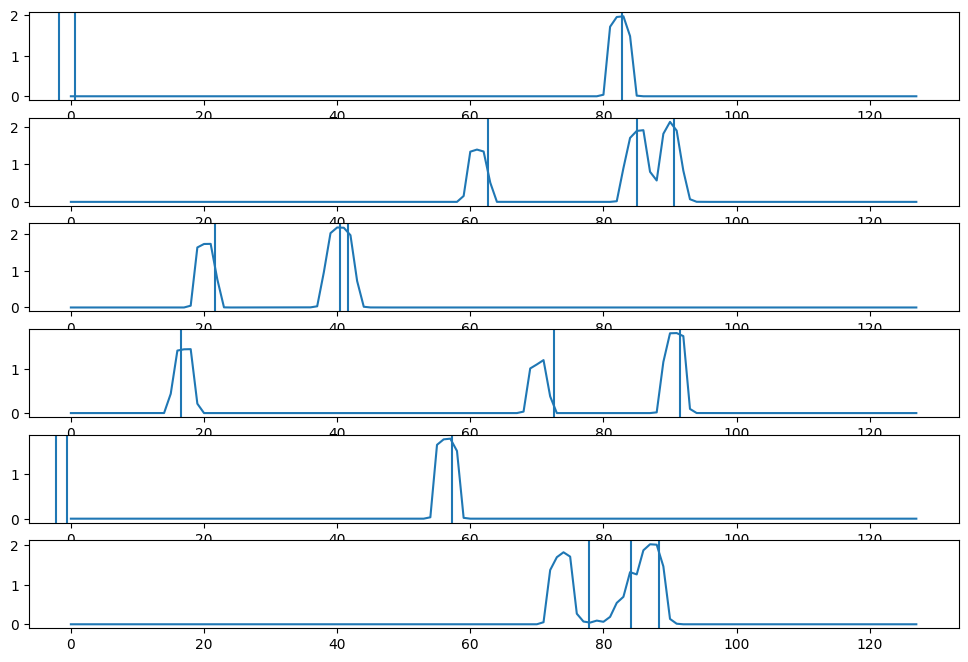

In [111]:
def plot_positions(X_train_2ch, model, indices):
    predictions = model.predict(X_train_2ch, verbose=0)
    
    figure, axes = plt.subplots(nrows=len(indices), ncols=1, squeeze=False, figsize=(12, 8))

    for ax, idx in zip(axes.flatten(), indices):
        
        ax.plot(X_train_2ch[idx, :, 0])

        for pos in predictions[idx]:
            ax.axvline(pos * 128)

    plt.show()

plot_positions(X_train_2ch, model, indices=[0, 1, 2, 3, 4, 5])